Linear Regression Results:
MSE: 0.6242
R2 Score: 0.7258

Random Forest Results:
MSE: 0.1114
R2 Score: 0.9511

Top 10 Most Important Features:
                 feature  importance
25             log_votes    0.957410
9             city_Other    0.012975
4            Price range    0.004340
2    Has Online delivery    0.002247
11       cuisine_chinese    0.002149
10  cuisine_north_indian    0.002001
0           Country Code    0.001792
16   cuisine_continental    0.001655
12     cuisine_fast_food    0.001585
13       cuisine_mughlai    0.001290


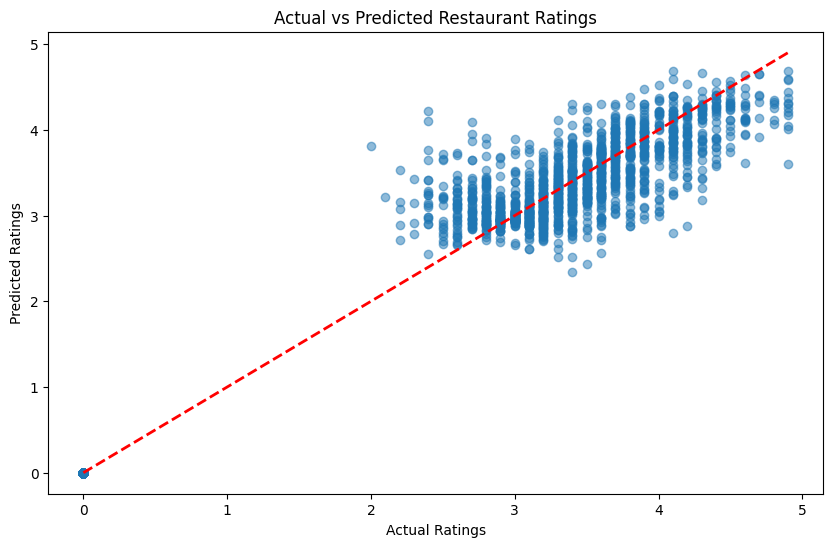

In [49]:
"""
COGNIFYZ TECHNOLOGIES - TASK 1
Restaurant Rating Prediction
Author: [Your Name]
Date: [Current Date]
"""

# 1. IMPORT LIBRARIES
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 2. DATA PREPROCESSING
def preprocess_data(data):
    """
    Preprocesses the restaurant dataset by removing unnecessary columns,
    encoding categorical variables, and handling feature engineering.
    """
    # Remove unnecessary columns
    columns_to_drop = ['Switch to order menu', 'Restaurant Name', 'Address',
                      'Locality', 'Locality Verbose', 'Currency', 'Rating color',
                      'Rating text', 'Restaurant ID', 'Average Cost for two',
                      'Longitude', 'Latitude']
    data.drop(columns_to_drop, inplace=True, axis=1)

    # Encode binary columns
    le = LabelEncoder()
    binary_columns = ['Has Table booking', 'Has Online delivery', 'Is delivering now']
    for column in binary_columns:
        data[column] = le.fit_transform(data[column])

    return data

# 3. CITY ENCODING
def encode_cities(data, threshold=250):
    """
    Encodes city information using dummy variables and groups smaller cities.
    """
    city_counts = data['City'].value_counts()
    major_cities = city_counts[city_counts >= threshold].index

    # Group cities
    data['City_grouped'] = data['City'].apply(lambda x: x if x in major_cities else 'Other')

    # Create dummy variables
    city_encoded = pd.get_dummies(data['City_grouped'], prefix='city')
    data = pd.concat([data, city_encoded], axis=1)
    data.drop(['City', 'City_grouped'], axis=1, inplace=True)

    return data

# 4. CUISINE ENCODING
def encode_cuisines(data, top_n=15):
    """
    Encodes cuisine information using dummy variables for top cuisines.
    """
    cuisines_list = data['Cuisines'].str.split(', ', expand=True).stack()
    cuisine_counts = cuisines_list.value_counts()
    top_cuisines = cuisine_counts.head(top_n).index

    # Create columns for top cuisines
    for cuisine in top_cuisines:
        data[f'cuisine_{cuisine.lower().replace(" ", "_")}'] = data['Cuisines'].apply(
            lambda x: 1 if isinstance(x, str) and cuisine in x else 0
        )

    data.drop('Cuisines', axis=1, inplace=True)
    return data

# 5. MODEL TRAINING AND EVALUATION
def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    """
    Trains and evaluates Linear Regression and Random Forest models.
    """
    # Linear Regression
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    lr_pred = lr_model.predict(X_test)
    lr_mse = mean_squared_error(y_test, lr_pred)
    lr_r2 = r2_score(y_test, lr_pred)

    # Random Forest
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    rf_pred = rf_model.predict(X_test)
    rf_mse = mean_squared_error(y_test, rf_pred)
    rf_r2 = r2_score(y_test, rf_pred)

    return (lr_model, rf_model, lr_mse, lr_r2, rf_mse, rf_r2, rf_pred)

# 6. VISUALIZATION
def plot_predictions(y_test, predictions):
    """
    Creates scatter plot of actual vs predicted ratings.
    """
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, predictions, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Ratings')
    plt.ylabel('Predicted Ratings')
    plt.title('Actual vs Predicted Restaurant Ratings')
    plt.show()

# 7. MAIN EXECUTION
def main():
    # Load data
    data = pd.read_csv('/content/Dataset .csv')

    # Preprocess data
    data = preprocess_data(data)
    data = encode_cities(data)
    data = encode_cuisines(data)

    # Prepare features
    X = data.drop('Aggregate rating', axis=1)
    y = data['Aggregate rating']

    # Log transform votes
    X['log_votes'] = np.log1p(X['Votes'])
    X = X.drop('Votes', axis=1)

    # Split and scale data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    numerical_cols = ['Country Code', 'Price range', 'log_votes']
    X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
    X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

    # Train and evaluate models
    lr_model, rf_model, lr_mse, lr_r2, rf_mse, rf_r2, rf_pred = train_and_evaluate_models(
        X_train, X_test, y_train, y_test
    )

    # Print results
    print("Linear Regression Results:")
    print(f"MSE: {lr_mse:.4f}")
    print(f"R2 Score: {lr_r2:.4f}")

    print("\nRandom Forest Results:")
    print(f"MSE: {rf_mse:.4f}")
    print(f"R2 Score: {rf_r2:.4f}")

    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)

    print("\nTop 10 Most Important Features:")
    print(feature_importance.head(10))

    # Plot results
    plot_predictions(y_test, rf_pred)

if __name__ == "__main__":
    main()

In [60]:
!cd Restaurant_Rating_Prediction